# Analysis of the KDD dataset

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
ls drive/MyDrive/KDD_Data/

dashboard.png  kddcup.data.corrected


In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar -xvzf spark-3.0.0-bin-hadoop2.7.tgz
!pip install findspark

In [7]:
ls

drive/  sample_data/  spark-3.0.0-bin-hadoop2.7/  spark-3.0.0-bin-hadoop2.7.tgz


In [ ]:
!pip install pyspark

In [9]:
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init()

In [28]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Analysing Data").getOrCreate()

In [29]:
from pyspark.sql import SparkSession, types, functions
from pyspark.sql.functions import udf

## Setting schema

In [30]:
# The KDD data schema
data_schema = types.StructType([
    types.StructField('duration', types.FloatType(), nullable=True),
    types.StructField('protocol_type', types.StringType(), nullable=True),
    types.StructField('service', types.StringType(), nullable=True),
    types.StructField('flag', types.StringType(), nullable=True),
    types.StructField('src_bytes', types.FloatType(), nullable=True),
    types.StructField('dst_bytes', types.FloatType(), nullable=True),
    types.StructField('land', types.FloatType(), nullable=True),
    types.StructField('wrong_fragment', types.FloatType(), nullable=True),
    types.StructField('urgent', types.FloatType(), nullable=True),
    types.StructField('hot', types.FloatType(), nullable=True),
    types.StructField('num_failed_logins', types.FloatType(), nullable=True),
    types.StructField('logged_in', types.FloatType(), nullable=True),
    types.StructField('num_compromised', types.FloatType(), nullable=True),
    types.StructField('root_shell', types.FloatType(), nullable=True),
    types.StructField('su_attempted', types.FloatType(), nullable=True),
    types.StructField('num_root', types.LongType(), nullable=True),
    types.StructField('num_file_creations', types.LongType(), nullable=True),
    types.StructField('num_shells', types.LongType(), nullable=True),
    types.StructField('num_access_files', types.LongType(), nullable=True),
    types.StructField('num_outbound_cmds', types.LongType(), nullable=True),
    types.StructField('is_host_login', types.FloatType(), nullable=True),
    types.StructField('is_guest_login', types.FloatType(), nullable=True),
    types.StructField('count', types.LongType(), nullable=True),
    types.StructField('srv_count', types.LongType(), nullable=True),
    types.StructField('serror_rate', types.FloatType(), nullable=True),
    types.StructField('srv_serror_rate', types.FloatType(), nullable=True),
    types.StructField('rerror_rate', types.FloatType(), nullable=True),
    types.StructField('srv_rerror_rate', types.FloatType(), nullable=True),
    types.StructField('same_srv_rate', types.FloatType(), nullable=True),
    types.StructField('diff_srv_rate', types.FloatType(), nullable=True),
    types.StructField('srv_diff_host_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_count', types.FloatType(), nullable=True),
    types.StructField('dst_host_srv_count', types.FloatType(), nullable=True),
    types.StructField('dst_host_same_srv_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_diff_srv_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_same_src_port_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_srv_diff_host_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_serror_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_srv_serror_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_rerror_rate', types.FloatType(), nullable=True),
    types.StructField('dst_host_srv_rerror_rate', types.FloatType(), nullable=True),
    types.StructField('attack', types.StringType(), nullable=True),
])

### Original Data Size:

In [31]:
data=spark.read.csv('drive/MyDrive/KDD_Data/kddcup.data.corrected',schema=data_schema)
print(data.count(),len(data.columns))

4898431 42


### Removing Duplicates:

In [32]:
df=data.dropDuplicates()
print(df.count(),len(df.columns))

1074992 42


### Analysing the attack column:

In [33]:
df.groupby(df["attack"]).agg(functions.count(df["attack"]).alias("count")).show()

+----------------+------+
|          attack| count|
+----------------+------+
|    warezmaster.|    20|
|          smurf.|  3007|
|            pod.|   206|
|           nmap.|  1554|
|           imap.|    12|
|   guess_passwd.|    53|
|        ipsweep.|  3723|
|      portsweep.|  3564|
|          satan.|  5019|
|           land.|    19|
|     loadmodule.|     9|
|      ftp_write.|     8|
|buffer_overflow.|    30|
|        rootkit.|    10|
|    warezclient.|   893|
|       teardrop.|   918|
|           perl.|     3|
|            phf.|     4|
|       multihop.|     7|
|        neptune.|242149|
+----------------+------+
only showing top 20 rows



## Creating Categories:
Basically lets categorise our attacks into broad categories.

First lets remove these dots from attack names.

In [34]:
df = df.withColumn("attack", functions.regexp_replace(df['attack'], "\.", ""))

In [35]:
def udf_categories(x):
    """
    User defined functions to filter categories based on different kinds of attacks
    Maps to the dictionary in python
    :param x: Input
    :return: mapped output
    """
    d = {'dos_attacks': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop',
                         'udpstorm', 'worm'],
         'probe_attacks': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
         'privilege_attacks': ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'],
         'access_attacks': ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail',
                            'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xclock', 'xsnoop'],
         'normal': ['normal']}
    for k, v in d.items():
        if x.strip().lower() in v:
            return k


def find_categories(df):
    """
    Specific function for mapping a udf to find broad attack categories
    :param df: Input data
    :return: Data with broad categories in a column name "categories"
    """
    xdf = udf(lambda x: udf_categories(x), types.StringType())
    df = df.withColumn('category', xdf(df['attack']))
    df = df.where(df['category'].isNotNull())
    return df


In [36]:
df=find_categories(df)

In [37]:
df.groupby(df["category"]).agg(functions.count(df["category"]).alias("count")).show()

+-----------------+------+
|         category| count|
+-----------------+------+
|privilege_attacks|    43|
|   access_attacks|   999|
|           normal|812814|
|    probe_attacks| 13860|
|      dos_attacks|247267|
+-----------------+------+



### Data is Skewed!!
Since this is a Big Data project, lets focus less on the ML accuracy and try and augment this data in a manner that all the classes are somewhat balanced.

For this:

1. We will reduce the number of neptune attacks (as this goes under dos)
2. Will rebalance the normal attack and try to distribute it among other 3 classes

In [38]:
def drop_selected_data(df, col, data_pt, keep=3000):
    """
    Removing extra entries for balancing the data (keeps first "keep" entries)
    :param df: Input data
    :param col: column with extra entries
    :param data_pt: name of the item which has extra entries
    :param keep: number of records to keep
    :return: output data with less records
    """
    df.createOrReplaceTempView("data_view")
    orig = spark.sql("select * from data_view where {}!='{}' ".format(col, data_pt))
    selected = spark.sql("select * from data_view where {}='{}' limit {}".format(col, data_pt, keep))
    final = orig.union(selected)
    return final

In [39]:
df = drop_selected_data(df, "attack", 'neptune', keep=20000)

In [40]:
def augment_data(df):
    df.createOrReplaceTempView("data_view")
    some_entries_df = spark.sql("select * from data_view where category='normal' limit 100000 ")
    remaining = df.withColumn("index", functions.monotonically_increasing_id())
    remaining = remaining.orderBy(functions.desc("index")).drop("index").limit(80000)
    no_normal = df.filter(df['category'] != 'normal')
    some_entries_df = some_entries_df.drop(some_entries_df["category"])
    some_entries_df = some_entries_df.withColumn(
        "category",
        functions.array(
            functions.lit("privilege_attacks"),
            functions.lit("probe_attacks"),
            functions.lit("access_attacks"),
        ).getItem(
            (functions.rand() * 3).cast("int")
        )
    )
    total = some_entries_df.union(remaining)
    final = no_normal.union(total)
    # analysis = final.groupby(final["category"]).agg(functions.count(final["category"]).alias("count"))
    return final

In [41]:
df=augment_data(df).cache()

In [42]:
df.groupby(df["category"]).agg(functions.count(df["category"]).alias("count")).show()

+-----------------+-----+
|         category|count|
+-----------------+-----+
|privilege_attacks|33618|
|   access_attacks|34110|
|           normal|58482|
|    probe_attacks|48313|
|      dos_attacks|45497|
+-----------------+-----+



### Ok now, this looks decent. Lets progress with using this as the basis of our analysis and plot some graphs.

### Lets analyse the average duration of the connections

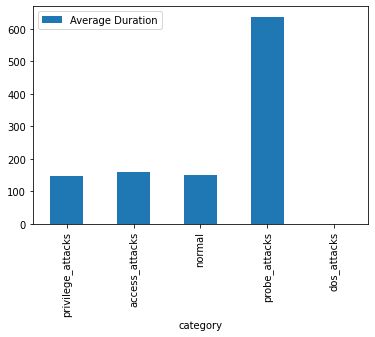

In [43]:
import matplotlib.pyplot as plt
cat_dur=df.groupby(df["category"]).agg(functions.avg(df["duration"]).alias("Average Duration")).toPandas()
cat_dur.plot(kind="bar",x='category',y='Average Duration')
plt.show()

In [26]:
cat_dur

,category,Average Duration
0,privilege_attacks,145.606609
1,access_attacks,156.945894
2,normal,149.154389
3,probe_attacks,641.526808
4,dos_attacks,0.007143


### Now lets see how many attacks attempted for a super user access


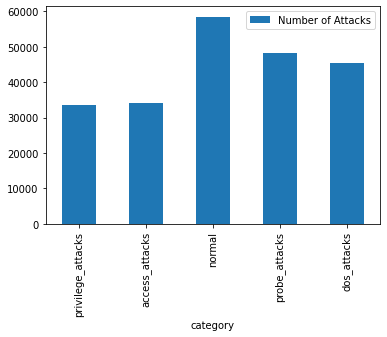

In [50]:
service_df=df.groupby(df["category"]).agg(functions.count(df["su_attempted"]).alias("Number of Attacks")).toPandas()
service_df.plot(kind="bar",x='category',y='Number of Attacks')
plt.show()

In [51]:
service_df

,category,Number of Attacks
0,privilege_attacks,33618
1,access_attacks,34110
2,normal,58482
3,probe_attacks,48313
4,dos_attacks,45497


## More analysis we have shown on a Tableau Dashboard

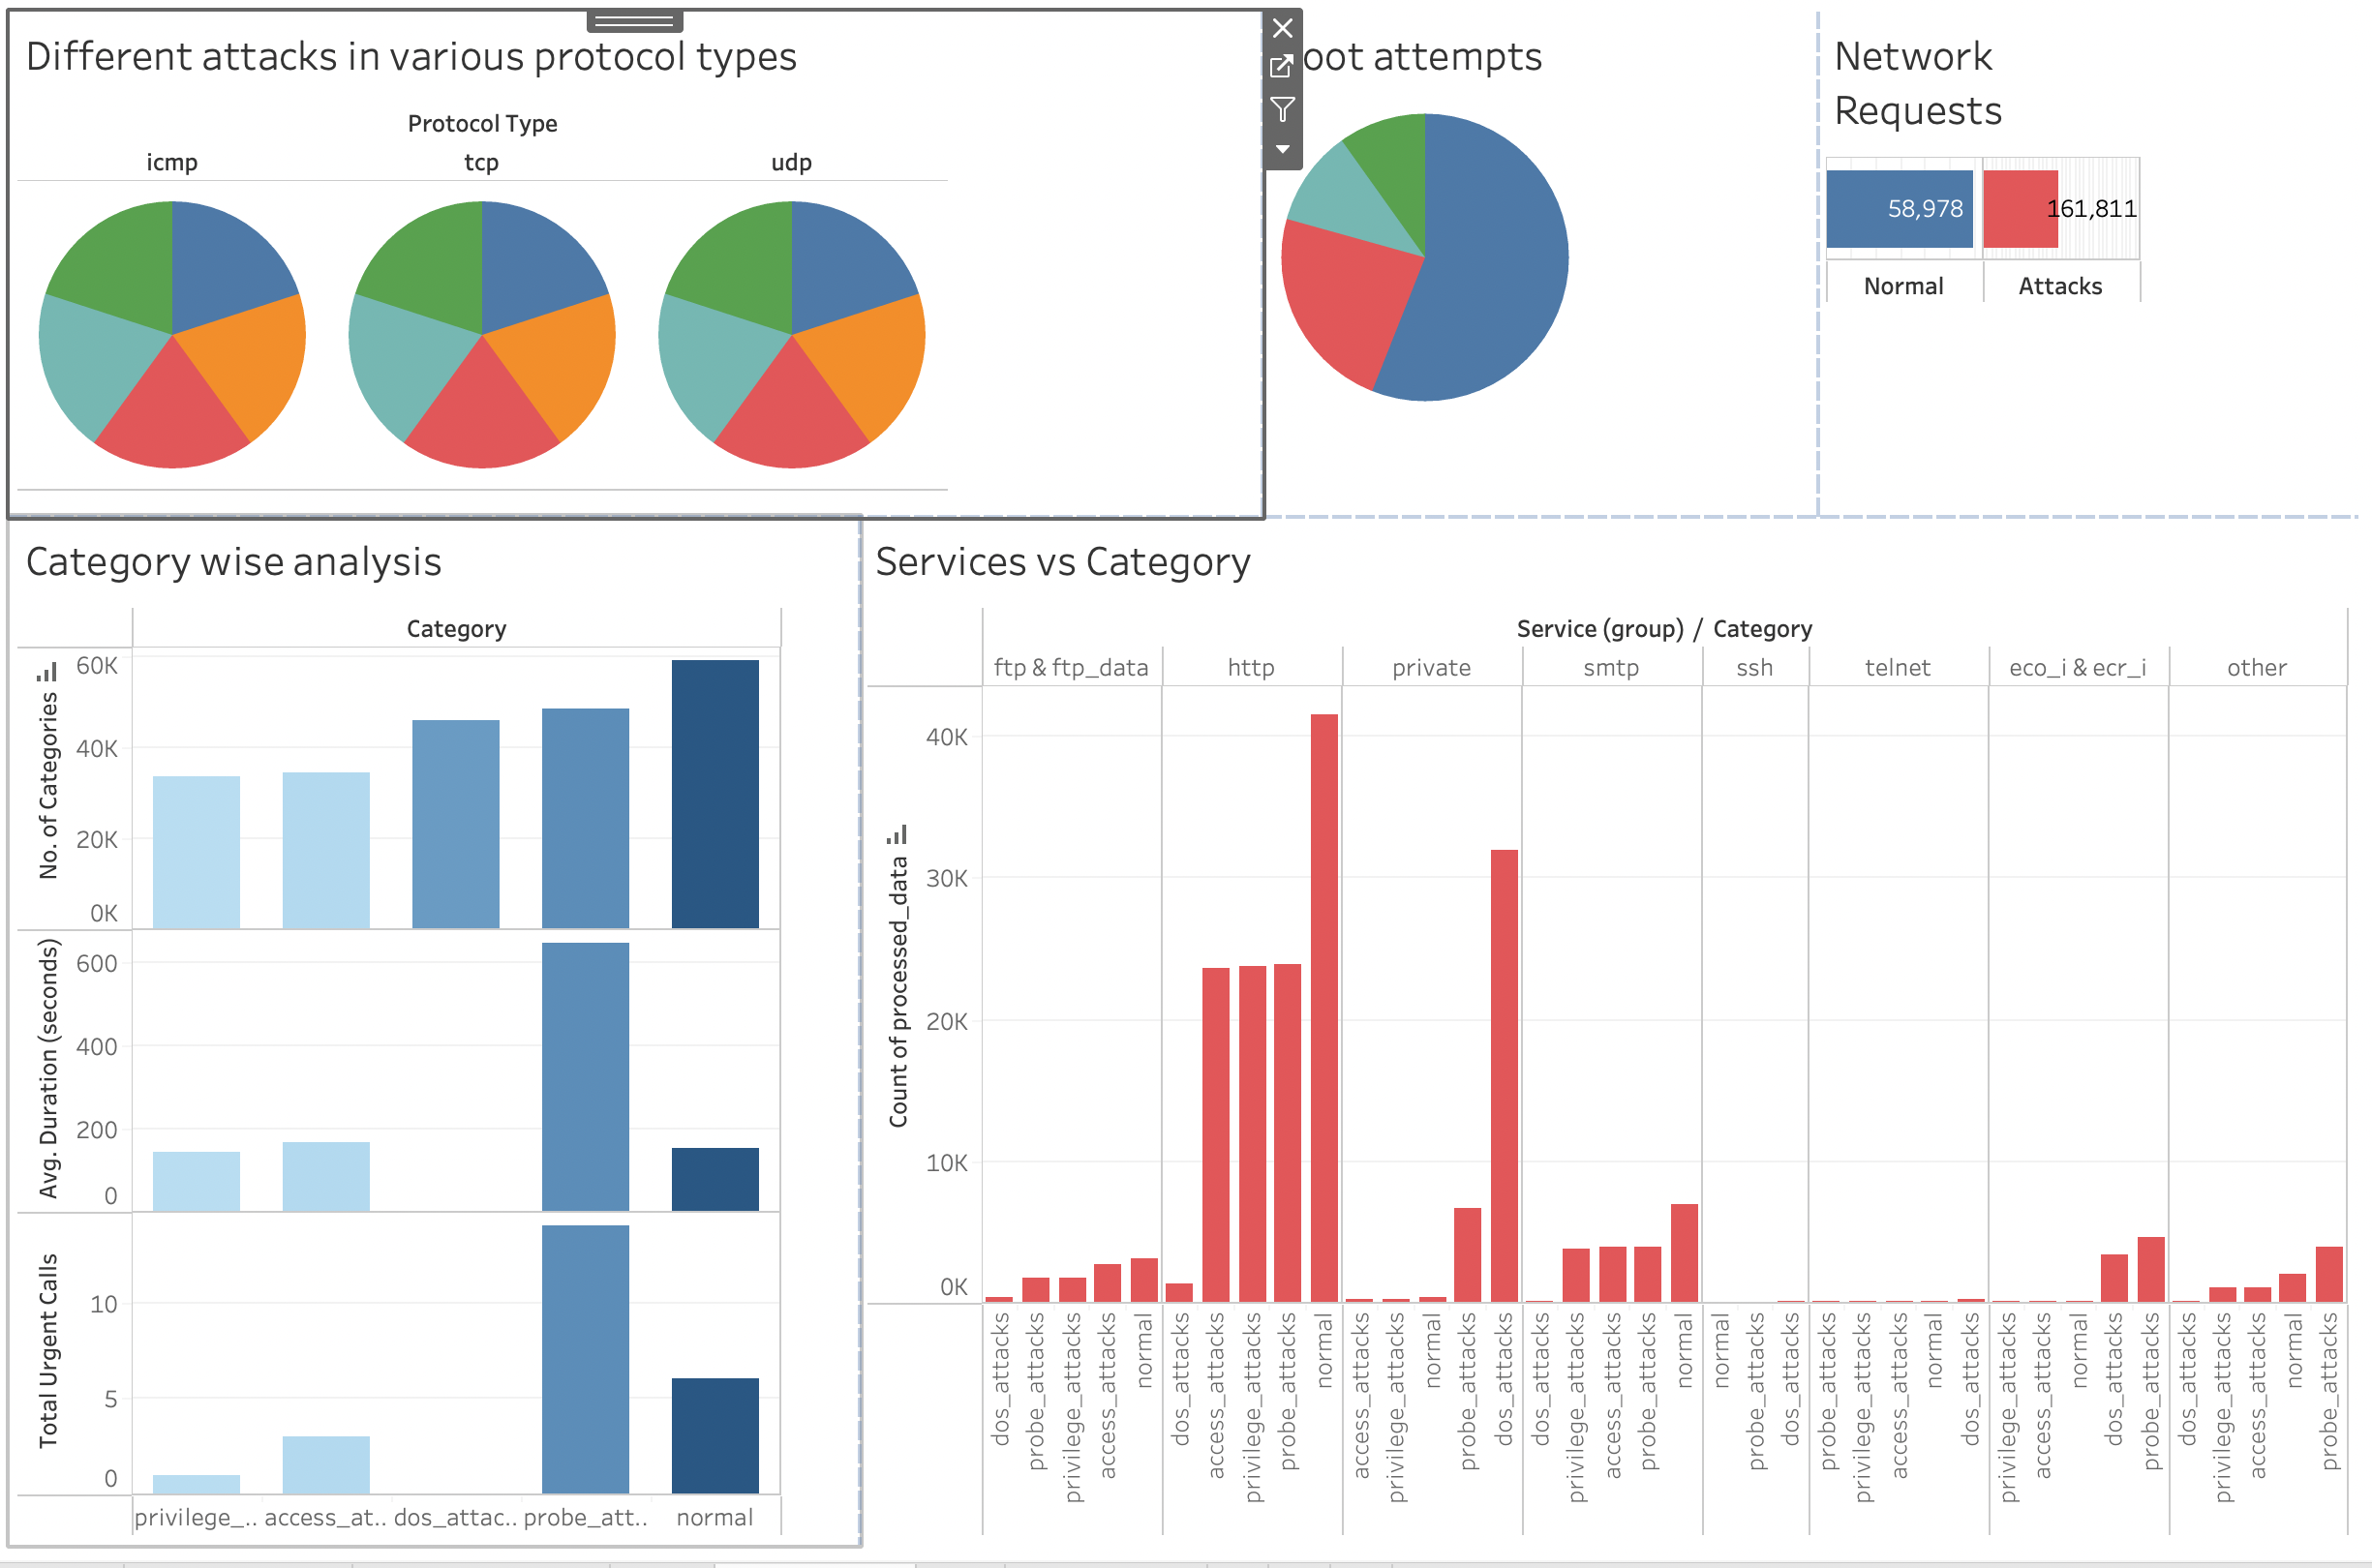

In [58]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread("drive/MyDrive/KDD_Data/dashboard.png")
cv2_imshow(img)